## Chapter 9: Algorithm Analysis

*Definition*: Consider two functions $f$ and $g$. We say that $f(n)$ is $O(g(n))$ or “big-O” of $g(n)$ if

$$ \lim_{n \rightarrow \infty} f(n) = C$$

for some $0<C<\infty$

Find big-O for the following:
* $n^2+e^n$
* $3n^2+e^{-n}$
* $n + n \ln (n)$

### Polynomial Evaluation

Recall that a polynomial is

$$p(x) = a_0 + a_1 x + a_2 x^2 + a_3 x^3 + \cdots + a_n x^n$$

For example, a quadratic is a polynomial like $q(x)= 3x^2+7x-2$

The simple way to evaluate the polynomial is to find each power of x and then multiply by the coefficient.  Here's a function that takes an array of coefficients and a value $x$ and calculates $p(x)$.  

In [16]:
function polyEval(coeffs::Vector{T}, x::S) where {T <: Number, S <: Number}
  local sum = zero(T)
  
  # we will use a simple power function that is not very efficient:
  function pow(x::T,n::Int) where T <: Number
    local prod = one(T)
    for j=1:n
      prod *=x
    end
    prod
  end
    
  # then we have the sum of all of the terms:
  for n=1:length(coeffs)
    sum += coeffs[n]*pow(x,n-1)
  end
  sum
end

polyEval (generic function with 1 method)

note: we will be explaining the `where {T <: Number, S <: Number}` later.  This allows the ability to evaluate polynomials at any type of number. 

The following evaluates $q(1.5)$ for the quadratic above

In [17]:
polyEval([-2,7,3],1.5)

15.25

And here is the polynomial $p(x)=1+2x+3x^2+4x^3$ evaluated at $x=4$

In [18]:
poly1([1,2,3,4],4)

313

We want to see how polynomial evaluation occurs for a given value of $n$, the degree of the polynomial.  We can do this two different ways:

1. Use some analytic techniques
2. Run some code and analyze.

For #1, we note that the number of multiplications for evaluating a polynomial of degree $n$ is

$$0+1+2+3+4+\cdots+(n+1)= \frac{(n+1)(n+2)}{2}$$

The number of additions is $n$. Overall the number of operations then is

$$\frac{(n+1)(n+2)}{2} +n$$

What is the order (big-o) of this?

For #2, we will do the following.  First need to load (and probably add) some packages

In [19]:
using BenchmarkTools, Plots, LsqFit

The following make an array of times that store the evaluate times of the polynomial evaluation.  Note: we use BigFloats to slow down the operations.  The point is the order

In [26]:
times = zeros(Float64,200)
for i=25:25:200
  coeffs = rand(BigFloat,i)
  times[i] = @belapsed polyEval($coeffs,1/big(3))
end

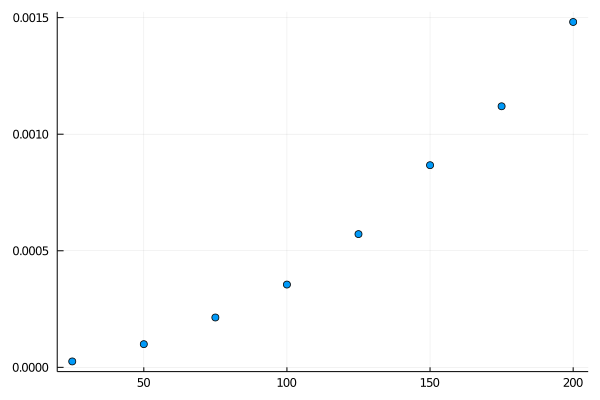

In [27]:
scatter(25:25:200,time[25:25:200],legend=false)

Although this looks quadratic, let's see if it is.  We can find the data to a quadratic using the following:

In [28]:
 model(t, p) = p[1].+p[2].*t.+p[3].*t.^2

model (generic function with 1 method)

In [29]:
fit = curve_fit(model, 25:25:200, times[25:25:200], [1e-8,1e-8,1e-8]);

And if we want the parameters

In [30]:
fit.param

3-element Array{Float64,1}:
  3.1692142857140726e-6
 -1.8058095238090032e-8
  3.7052647619047595e-8

The following is the confidence intervals for each of the paramters. 

In [32]:
confidence_interval(fit, 0.05)

3-element Array{Tuple{Float64,Float64},1}:
 (-6.290953251167518e-5, 6.924796108310333e-5)
 (-1.3656468421248715e-6, 1.3295306516486916e-6)
 (3.1205986742779216e-8, 4.2899308495315974e-8)

Because the first two contain 0, we don't include them and only use the 3rd (which is the $x^2$ term):

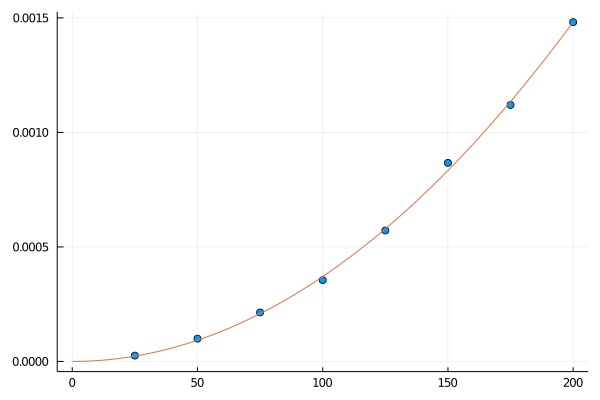

In [33]:
plot!(n->fit.param[3]*n^2,0:200)

Next, we are going to do an alternative way of evaluating a polynomial.  This is called Horner's form. 

In [34]:
function horner(coeffs::Vector{T},x::S) where {T <: Number, S <: Number}
  result = coeffs[end] 
  for i=length(coeffs)-1:-1:1
    result = x*result+coeffs[i]
  end
  result
end

horner (generic function with 1 method)

In [35]:
htime = zeros(Float64,200)
for i=25:25:200
  coeffs = rand(BigFloat,i)
  htime[i] = @belapsed horner($coeffs,1/big(3))
end

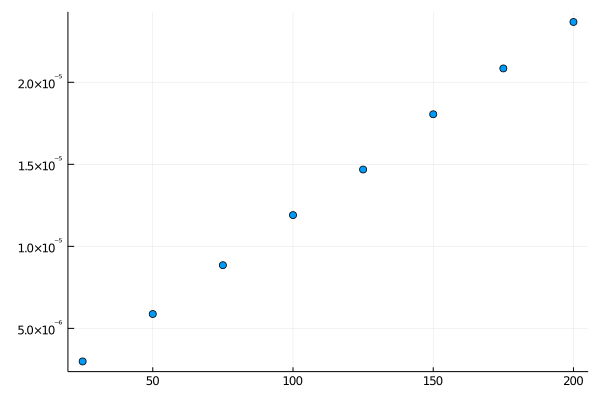

In [16]:
scatter(25:25:200,htime[25:25:200],legend=false)

In [36]:
fit2 = curve_fit(model, 25:25:200, htime[25:25:200], [1e-8,1e-8,1e-8]);

In [37]:
fit2.param

3-element Array{Float64,1}:
 -6.192409404713107e-8
  1.2047648780196467e-7
  5.1469048872457226e-11

In [38]:
confidence_interval(fit2)

3-element Array{Tuple{Float64,Float64},1}:
 (-2.053931995717973e-6, 1.9300838076237108e-6)
 (7.98521182110566e-8, 1.6110085739287275e-7)
 (-1.2478421300654236e-10, 2.277223107514568e-10)

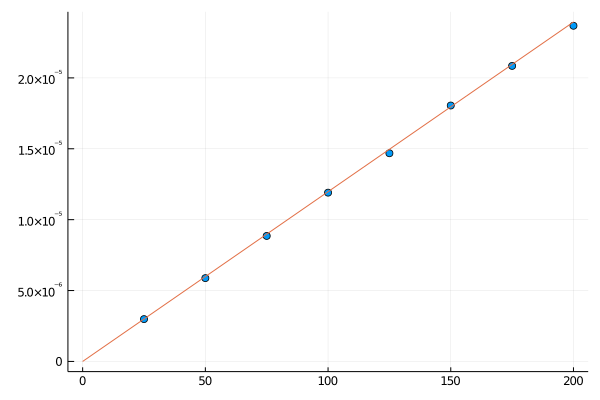

In [20]:
plot!(n->fit2.param[2]*n,0:200)

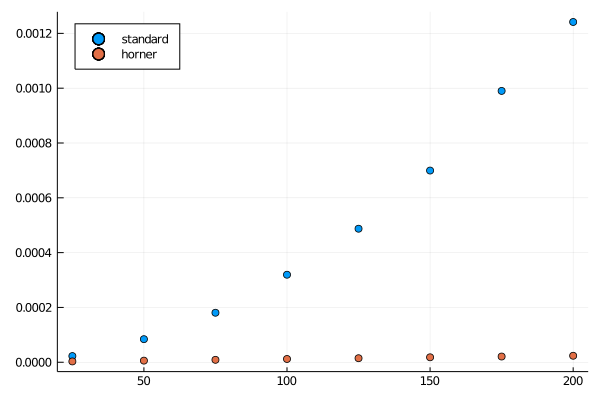

In [21]:
scatter(25:25:200,time[25:25:200],label="standard",legend=:topleft)
scatter!(25:25:200,htime[25:25:200],label="horner")

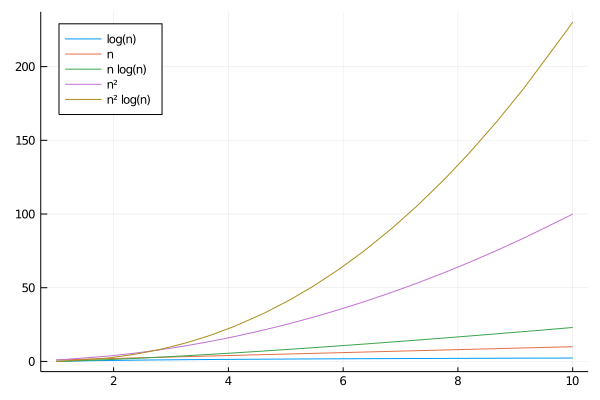

In [22]:
plot([x->log(x),x->x,x->x*log(x),x->x^2,x->x^2*log(x)],1,10,
    label=["log(n)" "n" "n log(n)"  "n²" "n² log(n)"],
    legend=:topleft)

### Testing the speed of Primes

In [23]:
function isPrime5(n::Integer)
  if n%2==0
    return false
  end
  for k=3:2:round(Int,sqrt(n))
    if n%k==0
      return false
    end
  end
  true
end

isPrime5 (generic function with 1 method)

In [24]:
using Primes

In [25]:
the_primes = map(nextprime,20_000_000:20_000_000:1_000_000_000)
times=zeros(Float64,length(the_primes))
for i=1:length(the_primes)
  times[i] = @belapsed isPrime5($the_primes[$i])
end

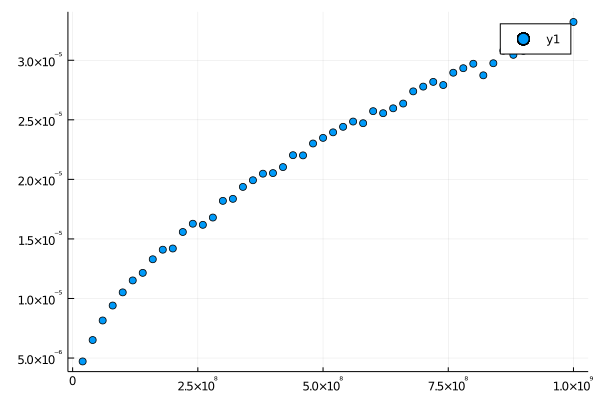

In [33]:
scatter(20_000_000:20_000_000:1_000_000_000,times)

In [44]:
 model2(t, p) = p[1].+p[2].*t.+p[3].*log.(t).+p[4].*t.*log.(t)

model2 (generic function with 1 method)

In [49]:
model2(t,p) = p[1].+p[2].*log.(t)

model2 (generic function with 1 method)

In [56]:
fit3 = curve_fit(model2,1:length(times), times, [-1e-4, 1e-8]);

In [57]:
fit3.param

2-element Array{Float64,1}:
 -2.469558339757281e-6
  8.314947267271669e-6

In [58]:
confidence_interval(fit3)

2-element Array{Tuple{Float64,Float64},1}:
 (-4.43377246341674e-6, -5.053442160978221e-7)
 (7.680770313972183e-6, 8.949124220571155e-6)

In [38]:
length(times)

50

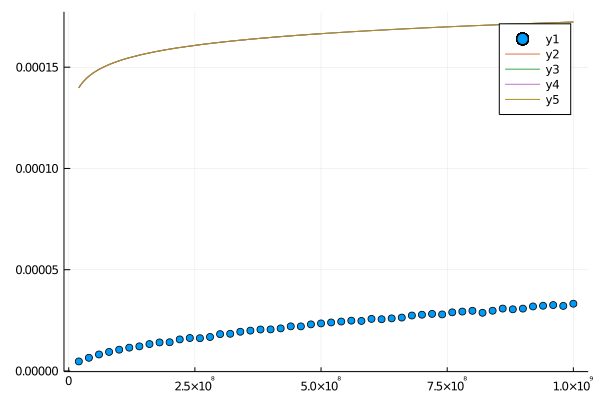

In [59]:
plot!(t->fit3.param[2]*log(t),20_000_000,1_000_000_000)

In [30]:
times3 = Float64[]
sizes3 = [250*n for n=1:10]
for size in sizes3
  A=rand(size,size)
  x=rand(size)
  push!(times3,@belapsed A*x)
end

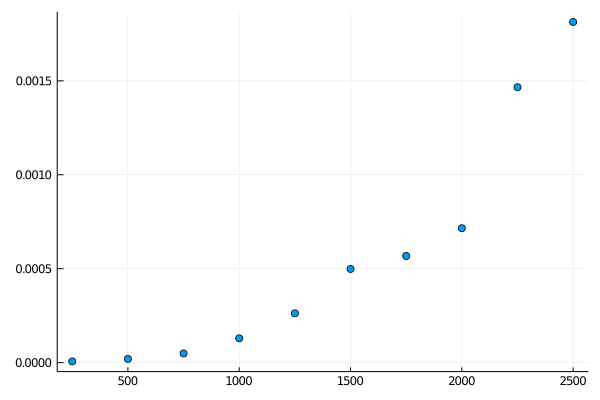

In [45]:
scatter(sizes3,times3, legend = false)

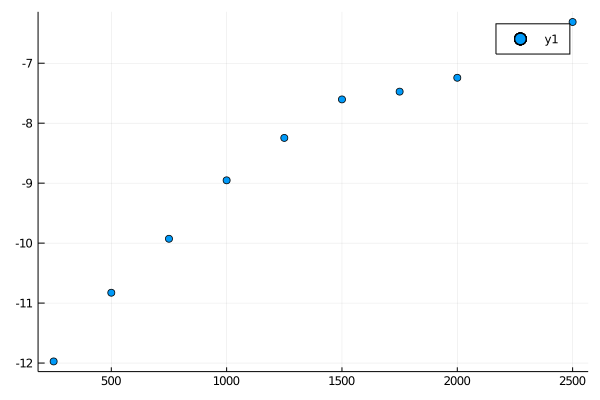

In [32]:
scatter(sizes3,log.(times3))

In [53]:
# model3(t, p) = p[1].*t.*log.(t)+p[2].*t.^2
model3(t,p)=p[1].*t.^2

model3 (generic function with 1 method)

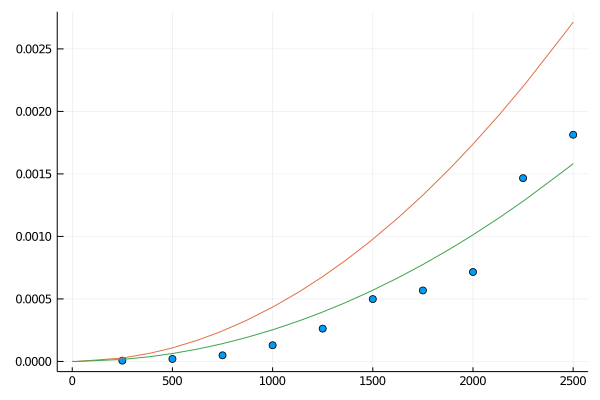

In [58]:
plot!(t->fit3.param[1]*t^2,0,2500)

In [59]:
using FFTW

In [116]:
times3 = Float64[]
sizes3 = [2^n for n=10:18]
for size in sizes3
  x=rand(size)
  t = @belapsed fft($x)
  push!(times3,t)
end

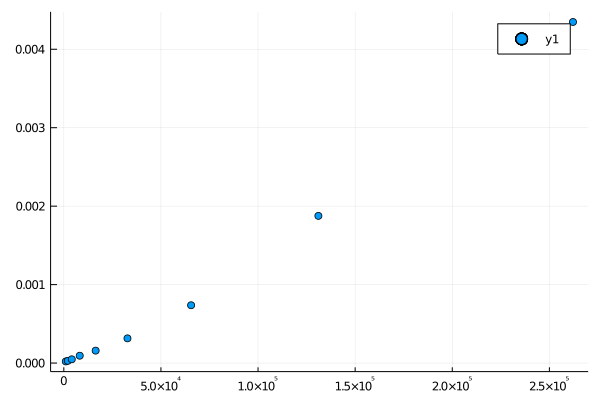

In [123]:
scatter(sizes3,times3)

In [117]:
model3(t, p) = p[1].*t + p[2].*t.*log.(t)+p[3].*t.^2

model3 (generic function with 1 method)

In [118]:
fit3 = curve_fit(model3,sizes3, times3, [1e-4,1e-4,1e-4]);

In [119]:
confidence_interval(fit3)

3-element Array{Tuple{Float64,Float64},1}:
 (-3.6579203458810267e-8, 9.190538857889106e-9)
 (1.4780086719839696e-10, 4.397396779802908e-9)
 (-7.237512339237511e-15, 2.2066183668344277e-14)

In [120]:
model3(t, p) = p[1].*t.*log.(t)

model3 (generic function with 1 method)

In [121]:
fit3 = curve_fit(model3,sizes3, times3, [1e-4]);

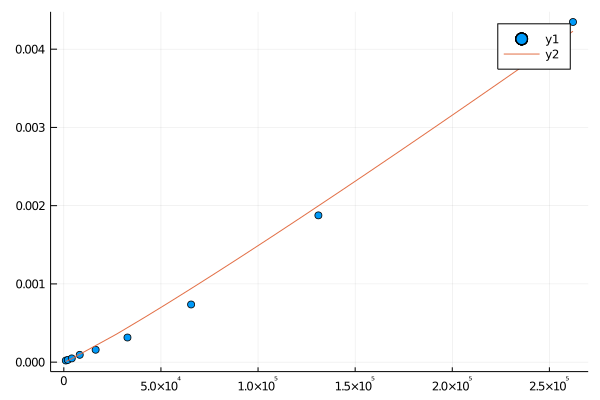

In [124]:
plot!(t->fit3.param[1]*t*log(t),first(sizes3),last(sizes3))